In [1]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import seaborn as sns
import copy, time, matplotlib, sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset
from torchsummary import summary

import torchvision
import torchvision.transforms as T

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
# plt.rcParams.update({'font.size':11})

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# ANN for regression

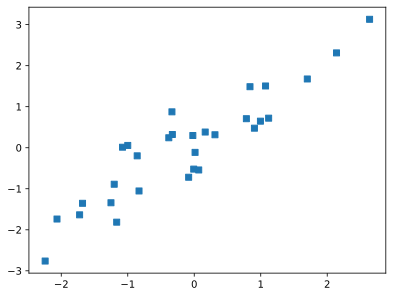

In [ ]:
# create data
N = 30
x = torch.randn(N,1)
y = x + torch.randn(N,1)/2

# and plot
plt.plot(x,y,'s')
plt.show()

In [ ]:
# build model
ANNreg = nn.Sequential(
    nn.Linear(1,1),                 # input layer
    nn.ReLU(),                      # activation function
    nn.Linear(1,1)                 # output layer
)

ANNreg

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
)

In [ ]:
learningRate = .05
lossfunc = nn.MSELoss()
optimizer = torch.optim.SGD(ANNreg.parameters(), lr=learningRate)

In [ ]:
# train the model
num_epochs = 500
losses = torch.zeros(num_epochs)

for epochi in range(num_epochs):

    # forward pass
    yHat =ANNreg(x)

    # compute loss
    loss = lossfunc(yHat, y)
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

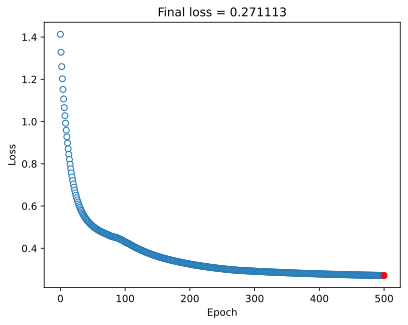

In [ ]:
# show the losses

# manually compute losses
# final forward pass
predictions = ANNreg(x)

# final loss (MSE)
testloss = (predictions - y).pow(2).mean()

plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=.1)
plt.plot(num_epochs, testloss.detach(), 'ro')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final loss = %g' %testloss.item())
plt.show()

In [ ]:
testloss.item()

0.2711127698421478

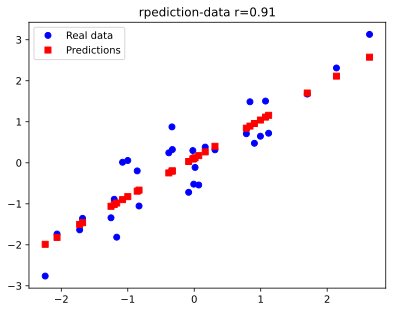

In [ ]:
# plot the data
plt.plot(x,y,'bo', label='Real data')
plt.plot(x, predictions.detach(), 'rs', label='Predictions')
plt.title(f'rpediction-data r={np.corrcoef(y.T, predictions.detach().T)[0,1]:.2f}')
plt.legend()
plt.show()

# Manipulate regression slopes

## A function that creates and trains the model

In [ ]:
def buildAndTrainTheModel(x,y):

    # build the model
    ANNreg = nn.Sequential(
        nn.Linear(1,1),
        nn.ReLU(),
        nn.Linear(1,1)
    )

    # loss and optimizer functions
    lossfunc = nn.MSELoss()
    optimizer = torch.optim.SGD(ANNreg.parameters(), lr=.05)

    ### train
    numepochs = 500
    losses = torch.zeros(numepochs)

    for epochi in range(numepochs):

        # forward pass
        yHat = ANNreg(x)

        # compute loss
        loss = lossfunc(yHat, y)
        losses[epochi] = loss

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # end training loop

    # compute model predictions
    predictions = ANNreg(x)

    return predictions, losses

## A function that creates the data

In [ ]:
def createTheData(m):
    N = 50
    x = torch.randn(N,1)
    y = m*x + torch.randn(N,1)/2
    return x, y

## Test it once

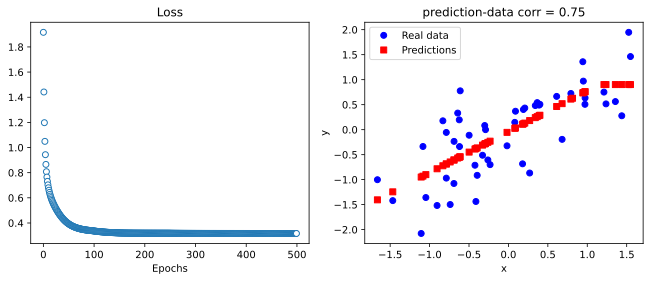

In [ ]:
# create a dataset
x,y = createTheData(.8)

# run the model
yHat, losses = buildAndTrainTheModel(x,y)
yHat = yHat.detach()

# plot
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(losses.detach(), 'o', markerfacecolor='w', linewidth=.1)
ax[0].set_xlabel('Epochs')
ax[0].set_title('Loss')

ax[1].plot(x,y,'bo', label='Real data')
ax[1].plot(x, yHat, 'rs', label='Predictions')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title(f'prediction-data corr = {np.corrcoef(y.T, yHat.T)[0,1]:.2f}')
ax[1].legend()

plt.show()

## Now for experiment!

In [ ]:
# the slopes to simulate
slopes = np.linspace(-2,2,21)

numExps = 50

# initialize output matrix
results = np.zeros((len(slopes), numExps, 2))

for slopei in range(len(slopes)):

    for N in range(numExps):

        # create a dataset and run the model
        x, y = createTheData(slopes[slopei])
        yHat, losses = buildAndTrainTheModel(x,y)

        # store the final loss and performance
        results[slopei, N, 0] = losses[-1]
        results[slopei, N, 1] = np.corrcoef(y.T, yHat.detach().T)[0,1]

# correlation can be 0 if the model didn't do well. Set nan's -> 0
results[np.isnan(results)] = 0

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


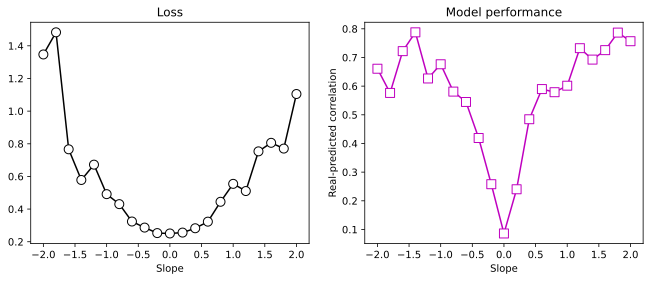

In [ ]:
# plot the results!
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(slopes, np.mean(results[:,:,0], axis=1), 'ko-', markerfacecolor='w', markersize=9)
ax[0].set_xlabel('Slope')
ax[0].set_title('Loss')

ax[1].plot(slopes, np.mean(results[:,:,1], axis=1), 'ms-', markerfacecolor='w', markersize=9)
ax[1].set_xlabel('Slope')
ax[1].set_ylabel('Real-predicted correlation')
ax[1].set_title('Model performance')

plt.show()

In [ ]:
''' Why were losses larger with larger slopes, even though the fit to the data was better?
- Losses are not normalized; they are in the scale of the data. Larger slopes led to more variance in y.
- Losses can only be compared on the same data, or on different datasets that are normalized to the same numeric range.

Why did model accuracy drop when the slopes were closer to zero?
- x is less informative about y when the slope decreses. The model had less useful information about y.
- ANNs (and DL in general) don't predict data values; they learn relationships across variables (which might be too complex for humans).
'''

# ANN for classifying qwerties

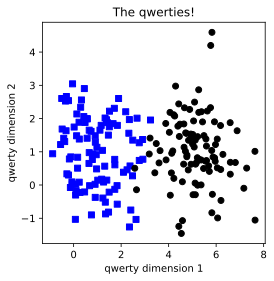

In [ ]:
# create data
nPerClust = 100
blur = 1

A = [1,1]
B = [5,1]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.vstack((
    np.zeros((nPerClust, 1)),
    np.ones((nPerClust, 1))
))

# concatenate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(4,4))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bs')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [ ]:
# build the model
ANNclassify = nn.Sequential(
    nn.Linear(2,1),
    nn.ReLU(),
    nn.Linear(1,1),
    nn.Sigmoid()
)

In [ ]:
ANNclassify

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Sigmoid()
)

In [ ]:
# other model features
learning_rate = .01
lossfunc = nn.BCELoss() # better to use BCEWithLogitsLoss
optimizer = torch.optim.SGD(ANNclassify.parameters(), lr=learning_rate)

In [ ]:
# train the model
num_epochs = 1000
losses = torch.zeros(num_epochs)

for epochi in range(num_epochs):

    # forward pass
    yHat = ANNclassify(data)

    # compute loss
    loss = lossfunc(yHat, labels)
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

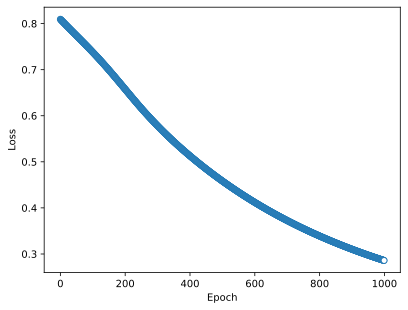

In [ ]:
# show the losses
plt.plot(losses, 'o', markerfacecolor='w', linewidth=.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# compute the predictions

# manually compute losses
# final forward pass
predictions = ANNclassify(data)

predlabels = predictions > .5

# find errors
misclassified = np.where(predlabels != labels)[0]

# total accuracy
total_acc = 100 - 100*len(misclassified) / (2*nPerClust)

print('Final accuracy: %g%%' %total_acc)

Final accuracy: 92.5%


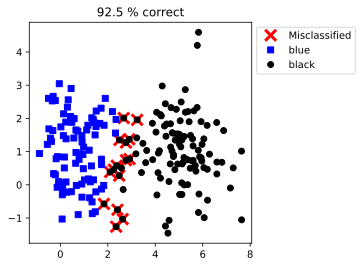

In [ ]:
# plot the labeled data
fig = plt.figure(figsize=(4,4))
plt.plot(data[misclassified,0], data[misclassified,1], 'rx', markersize=11, markeredgewidth=3)
plt.plot(data[np.where(~predlabels)[0],0], data[np.where(~predlabels)[0],1], 'bs')
plt.plot(data[np.where(predlabels)[0],0], data[np.where(predlabels)[0],1], 'ko')

plt.legend(['Misclassified', 'blue', 'black'], bbox_to_anchor=(1,1))
plt.title(f'{total_acc} % correct')
plt.show()

# Learning rates comparison

## Functions to build and train the model

In [ ]:
def createANNmodel(learningRate):

    # model architecture
    ANNclassify = nn.Sequential(
        nn.Linear(2,1), # input layer
        nn.ReLU(), # activation function
        nn.Linear(1,1), # output layer
        # nn.Sigmoid(), # final activation unit (not needed b/c we use BCEWithLogitsLoss)
    )

    # loss function
    lossfunc = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNclassify.parameters(), lr=learningRate)

    # function output
    return ANNclassify, lossfunc, optimizer

In [ ]:
# a function that trains the model

# a fixed parameter
numepochs = 1000

def trainTheModel(ANNmodel, lossfunc, optimizer):

    # initialize losses
    losses = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # forward pass
        yHat = ANNmodel(data)

        # compute loss
        loss = lossfunc(yHat, labels)
        losses[epochi] = loss.item()

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # final forward pass
    predictions = ANNmodel(data)

    # compute the predictions and report accuracy
    # NOTE: shouldn't it be predictions>.5?
    total_acc = 100 * torch.mean(((predictions>0) == labels).float()).item()

    return losses, predictions, total_acc

## Test the new code by running it once

Final accuracy: 94.5%


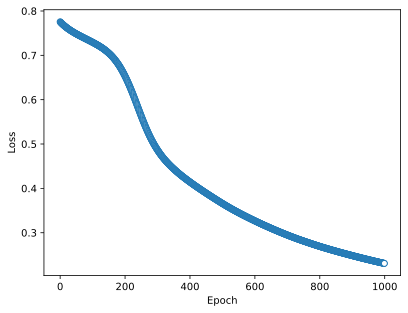

In [ ]:
# create everything
ANNclassify, lossfunc, optimizer = createANNmodel(.01)

# run it
losses, predictions, total_acc = trainTheModel(ANNclassify, lossfunc, optimizer)

# report accuracy
print('Final accuracy: %g%%' %total_acc)

# show the losses
plt.plot(losses, 'o', markerfacecolor='w', linewidth=.1)
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.show()

## Now for the experiment

In [ ]:
# the set of learning rates to test
learning_rates = np.linspace(.001, .1, 40)

# initialize results output
accByLR = []
allLosses = np.zeros((len(learning_rates), numepochs))

# loop through learning rates
for i, lr in enumerate(learning_rates):

    # create and run the model
    ANNclassify, lossfunc, optimizer = createANNmodel(lr)
    losses, predictions, total_acc = trainTheModel(ANNclassify, lossfunc, optimizer)

    # store the results
    accByLR.append(total_acc)
    allLosses[i, :] = losses

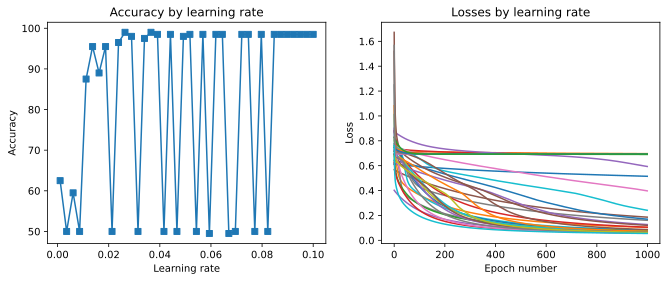

In [ ]:
# plot the results
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(learning_rates, accByLR, 's-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(allLosses.T)
ax[1].set_title('Losses by learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
plt.show()

In [ ]:
'''
- Sometimes the model got lucky with an initial weight randomization.
- This means that chance played a large role in our conclusions.
- New experiment: Repeat the previous experiment 50 times and average the results.
'''

In [ ]:
# proportion of runs where the model had at least 70% accuracy
sum(torch.tensor(accByLR)>70) / len(accByLR)

tensor(0.6500)

## Run a meta-experiment to get more reliable results

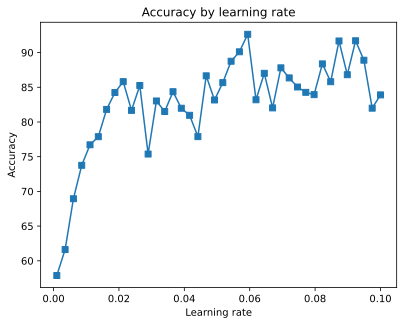

In [ ]:
# run a "meta-experiment" by repeating the experiment N times
#  (different random weight initializations each time)
# note: this cell takes ~7 mins.

# number of times to iterate through the experiment
numExps = 50

# matrix to store all results
accMeta = np.zeros((numExps, len(learning_rates)))

# fewer epochs to reduce computation time
num_epochs = 500

# now for the experiment
for expi in range(numExps):
    for i, lr in enumerate(learning_rates):

        # create and run the model
        ANNclassify, lossfunc, optimizer = createANNmodel(lr)
        losses, predictions, total_acc = trainTheModel(ANNclassify, lossfunc, optimizer)

        # store the results
        accMeta[expi, i] = total_acc

# now plot the results, averaged over experiments
plt.plot(learning_rates, np.mean(accMeta, axis=0), 's-')
plt.xlabel('Learning rate')
plt.ylabel('Accuracy')
plt.title('Accuracy by learning rate')
plt.show()

# Multi-layer ANN

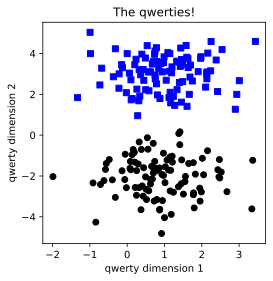

In [ ]:
# create data
nPerClust = 100
blur = 1

A = [1,3]
B = [1,-2]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.vstack((
    np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))
))

# concatenate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(4,4))
plt.plot(data[np.where(labels==0)[0], 0], data[np.where(labels==0)[0], 1], 'bs')
plt.plot(data[np.where(labels==1)[0], 0], data[np.where(labels==1)[0], 1], 'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

## Functions to build and train the model

In [ ]:
def createANNmodel(learingRate):

    # model architecture
    ANNclassify = nn.Sequential(
        nn.Linear(2,16),                        # input layer
        nn.ReLU(),                                # activation unit
        nn.Linear(16,1),                        # hidden layer
        nn.ReLU(),                                # activation unit
        nn.Linear(1,1),                          # output layer
        nn.Sigmoid(),                            # final activation unit
    )

    # loss function
    lossfunc = nn.BCELoss() # but better to use BCEWithLogitsLoss

    # optimizer
    optimizer = torch.optim.SGD(ANNclassify.parameters(), lr=learningRate)

    return ANNclassify, lossfunc, optimizer

In [ ]:
# a function that trains the model

# a fixed parameter
numepochs = 1000

def trainTheModel(ANNmodel, lossfunc, optimizer):

    # intialize losses
    losses = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # forward pass
        yHat = ANNmodel(data)

        # compute loss
        loss = lossfunc(yHat, labels)
        losses[epochi] = loss.item()

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # final forward pass
    predictions = ANNmodel(data)

    # compute the predictions and report accuracy
    total_acc = 100 * torch.mean(((predictions>.5)==labels).float()).item()

    return losses, predictions, total_acc

## Test the new code by running it once

Final accuracy: 100%


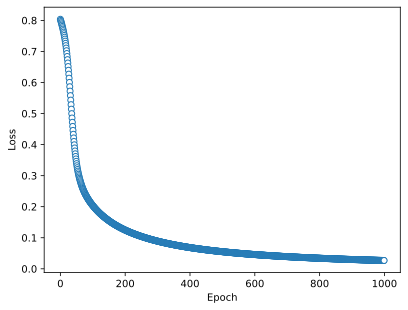

In [ ]:
# create everything
ANNclassify, lossfunc, optimizer = createANNmodel(.01)

# run it
losses, predictions, total_acc = trainTheModel(ANNclassify, lossfunc, optimizer)

# report accuracy
print('Final accuracy: %g%%' % total_acc)

# show the losses
plt.plot(losses, 'o', markerfacecolor='w', linewidth=.1)
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.show()

## Now for the real test (varying learning rates)

In [ ]:
# learning rates
learning_rates = np.linspace(.001, .1, 50)

# initialize
accByLR = []
allLosses = np.zeros((len(learning_rates), numepochs))

# the loop
for i, lr in enumerate(learning_rates):

    # create and run the model
    ANNclassify, lossfunc, optimizer = createANNmodel(lr)
    losses, predictions, total_acc = trainTheModel(ANNclassify, lossfunc, optimizer)

    # store the results
    accByLR.append(total_acc)
    allLosses[i, :] = losses

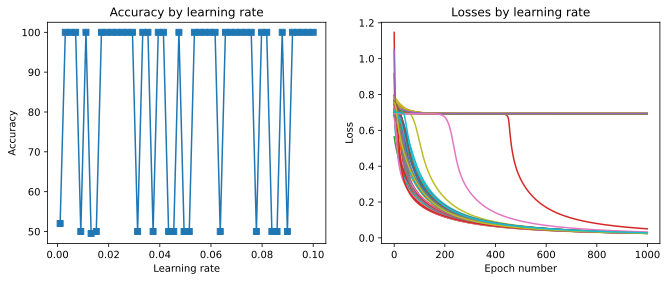

In [ ]:
# plot the results
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(learning_rates, accByLR, 's-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(allLosses.T)
ax[1].set_title('Losses by learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
plt.show()

In [ ]:
sum(torch.tensor(accByLR)>70) / len(accByLR)

tensor(0.7000)

# Linear solutions to linear problems

In [ ]:
def createANNmodel(learingRate):

    # model architecture
    ANNclassify = nn.Sequential(
        nn.Linear(2,16),                        # input layer
        # nn.ReLU(),                                # activation unit
        nn.Linear(16,1),                        # hidden layer
        # nn.ReLU(),                                # activation unit
        nn.Linear(1,1),                          # output layer
        nn.Sigmoid(),                            # final activation unit
    )

    # loss function
    lossfunc = nn.BCELoss() # but better to use BCEWithLogitsLoss

    # optimizer
    optimizer = torch.optim.SGD(ANNclassify.parameters(), lr=learningRate)

    return ANNclassify, lossfunc, optimizer

In [ ]:
# learning rates
learning_rates = np.linspace(.001, .1, 50)

# initialize
accByLR = []
allLosses = np.zeros((len(learning_rates), numepochs))

# the loop
for i, lr in enumerate(learning_rates):

    # create and run the model
    ANNclassify, lossfunc, optimizer = createANNmodel(lr)
    losses, predictions, total_acc = trainTheModel(ANNclassify, lossfunc, optimizer)

    # store the results
    accByLR.append(total_acc)
    allLosses[i, :] = losses

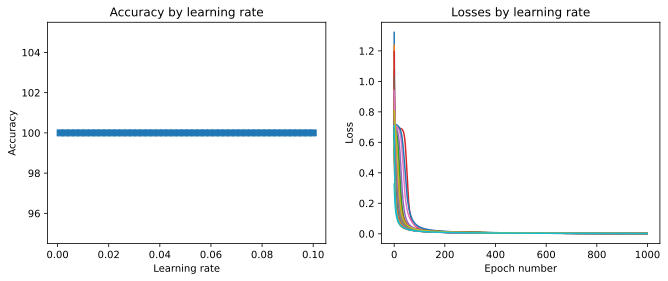

In [ ]:
# plot the results
fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(learning_rates, accByLR, 's-')
ax[0].set_xlabel('Learning rate')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy by learning rate')

ax[1].plot(allLosses.T)
ax[1].set_title('Losses by learning rate')
ax[1].set_xlabel('Epoch number')
ax[1].set_ylabel('Loss')
plt.show()

In [ ]:
sum(torch.tensor(accByLR)>70) / len(accByLR)

tensor(1.)

In [ ]:
'''
- Simple problems require simple solutions.
- Qwerties are linearly separable, so a linear separator will out-perform a nonlinear separator.
- Nonlinear models (basically all of DL) are best-suited for complex nonlinear problems.
- Appropriate methods for separating qwerties include a logistic regression and k-means.

- Don't throw a complicated DL model at every problem, just because you can.
- Approach every problem with an open, analytic, creative, and critical mind.
'''

# Why multi-layer linear models don't exist

In [ ]:
''' Why a "multi-layer" linear model is really just one layer, as long as there are no nonlinear activation units.
- Layers collapse without nonlinearities
'''

# Multi-output ANN (iris dataset)

## Import and process the data

In [ ]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris', cache=False)

# check out the first few lines of data
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


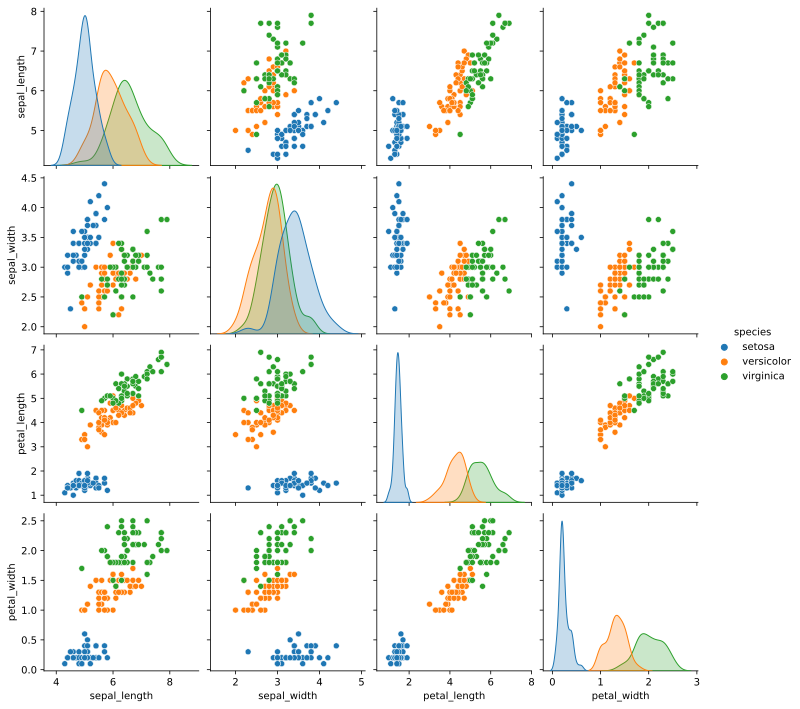

In [ ]:
# some plots to show the data
sns.pairplot(iris, hue='species')
plt.show()

In [ ]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Create the ANN model

In [ ]:
# model architecture
ANNiris = nn.Sequential(
    nn.Linear(4,64),                # input layer
    nn.ReLU(),                        # activation
    nn.Linear(64,64),              # hidden layer
    nn.ReLU(),                       # activation
    nn.Linear(64,3),                # output layer
)

# loss function
lossfunc = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.01)

## Train the model

In [ ]:
numepochs = 1000

# initialize losses
losses = torch.zeros(numepochs)
ongoingAcc = []

# loop over epochs
for epochi in range(numepochs):

    # forward pass
    yHat = ANNiris(data)

    # compute loss
    loss = lossfunc(yHat, labels)
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # compute accuracy
    matches = torch.argmax(yHat, axis=1) == labels
    matchesNumeric = matches.float()
    accuracyPct = 100 * torch.mean(matchesNumeric).item()
    ongoingAcc.append(accuracyPct)

# final forward pass
predictions = ANNiris(data)

predlabels = torch.argmax(predictions, axis=1)

total_acc = 100 * torch.mean( (predlabels==labels).float() )

In [ ]:
total_acc

tensor(98.)

In [ ]:
yHat.shape

torch.Size([150, 3])

In [ ]:
torch.argmax(yHat, axis=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

## Visualize the results

Final accuracy: 98%


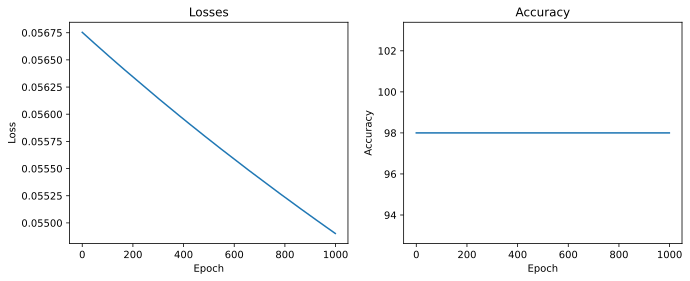

In [ ]:
# repoart accuracy
print('Final accuracy: %g%%' %total_acc)

fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(losses)
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Losses')

ax[1].plot(ongoingAcc)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
plt.show()

In [ ]:
# confirm that all model predictions sum to 1, but only when converted to softmax
sm = nn.Softmax(1)
torch.sum(yHat, axis=1)

tensor([-0.4308, -0.4547, -0.3999, -0.3958, -0.4302, -0.4657, -0.3814, -0.4087,
        -0.3828, -0.4259, -0.4479, -0.3895, -0.4082, -0.4071, -0.5632, -0.5130,
        -0.5009, -0.4334, -0.5129, -0.4269, -0.5144, -0.4276, -0.4975, -0.5341,
        -0.4222, -0.5039, -0.4782, -0.4272, -0.4412, -0.4109, -0.4484, -0.5310,
        -0.4651, -0.5109, -0.4504, -0.4485, -0.4881, -0.4270, -0.3636, -0.4243,
        -0.4423, -0.5272, -0.3804, -0.5020, -0.4532, -0.4606, -0.4093, -0.3732,
        -0.4387, -0.4184, -0.9871, -0.9032, -0.9580, -0.7762, -0.9081, -0.7586,
        -0.8548, -0.6928, -0.9317, -0.7218, -0.7278, -0.8326, -0.8549, -0.8167,
        -0.8027, -0.9557, -0.7309, -0.7919, -0.8512, -0.7929, -0.7483, -0.8788,
        -0.8283, -0.8233, -0.9102, -0.9462, -0.9494, -0.8968, -0.8166, -0.8009,
        -0.7868, -0.7756, -0.8271, -0.7368, -0.6878, -0.8157, -0.9408, -0.8920,
        -0.7795, -0.7766, -0.7305, -0.8298, -0.8302, -0.7149, -0.7740, -0.7834,
        -0.7966, -0.8796, -0.7361, -0.80

In [ ]:
torch.sum(sm(yHat), axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

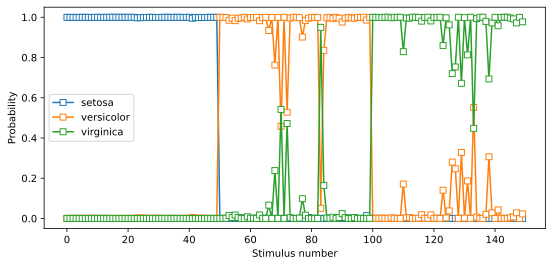

In [ ]:
# plot the raw model outputs

fig = plt.figure(figsize=(9,4))

plt.plot(sm(yHat.detach()), 's-', markerfacecolor='w')
plt.xlabel('Stimulus number')
plt.ylabel('Probability')
plt.legend(['setosa', 'versicolor', 'virginica'])
plt.show()

# More qwerties!

## Import and process the data

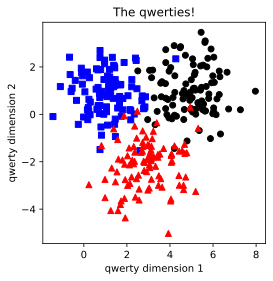

In [ ]:
# create data
nPerClust = 100
blur = 1

A = [1,1]
B = [5,1]
C = [3,-2]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur, C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.vstack((
    np.zeros((nPerClust,1)), np.ones((nPerClust,1)), 1+np.ones((nPerClust, 1))
))

# concatenate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.squeeze(torch.tensor(labels_np).long())

# show the data
fig = plt.figure(figsize=(4,4))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bs')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ko')
plt.plot(data[np.where(labels==2)[0],0], data[np.where(labels==2)[0],1], 'r^')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

## Create the ANN model

In [ ]:
# model architecture
ANNq = nn.Sequential(
    nn.Linear(2,4),                 # input layer
    nn.ReLU(),                       # activation unit
    nn.Linear(4,3),                 # output layer
    nn.Softmax(dim=1),         # final activation unit
)

# loss function
lossfunc = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(ANNq.parameters(), lr=.01)

In [ ]:
# test the model
yHat = ANNq(data)

print(data.shape)
print(yHat.shape)

torch.Size([300, 2])
torch.Size([300, 3])


In [ ]:
yHat

## Train the model

In [ ]:
numepochs = 10000

# initialize losses
losses = torch.zeros(numepochs)
ongoingAcc = []

# loop over epochs
for epochi in range(numepochs):

    # forward pass
    yHat = ANNq(data)

    # compute loss
    loss = lossfunc(yHat, labels)
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # compute accuracy
    matches = torch.argmax(yHat, axis=1) == labels
    matchesNumeric = matches.float()
    accuracyPct = 100 * torch.mean(matchesNumeric)
    ongoingAcc.append(accuracyPct)

# final forward pass
predictions = ANNq(data)

predlabels = torch.argmax(predictions, axis=1)
total_acc = 100 * torch.mean((predlabels==labels).float())

## Visualize the results

Final accuracy: 93%


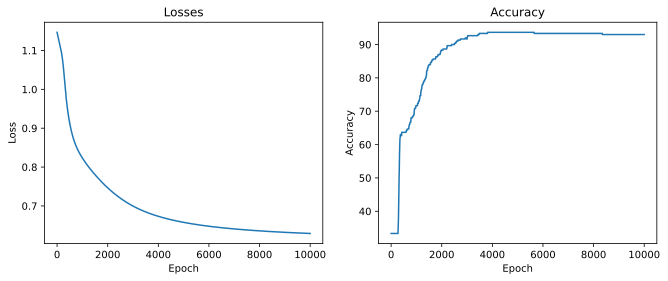

In [ ]:
# report accuracy
print('Final accuracy: %g%%' % total_acc)

fig, ax = plt.subplots(1,2,figsize=(11,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Losses')

ax[1].plot(ongoingAcc)
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')

plt.show()

In [ ]:
# confirm that all model predictions sum to 1
torch.sum(yHat, axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

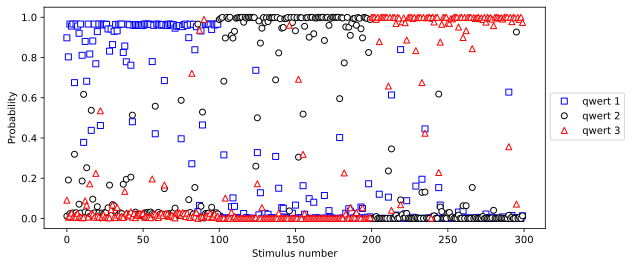

In [ ]:
# plot the raw model outputs
fig = plt.figure(figsize=(9,4))

colorshape=['bs', 'ko', 'r^']

for i in range(3):
    plt.plot(yHat[:,i].detach(), colorshape[i], markerfacecolor='w')

plt.xlabel('Stimulus number')
plt.ylabel('Probability')
plt.legend(['qwert 1', 'qwert 2', 'qwert 3'], loc=(1.01, .4))
plt.show()

# Comparing the number of hidden units

## Import and organize the data

In [ ]:
# import dataset
iris = sns.load_dataset('iris', cache=False)

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [ ]:
# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

## Functions to create and train the model

In [ ]:
def createIrisModel(nHidden):

    # model architecture (with number of units soft-coded!)
    ANNiris = nn.Sequential(
        nn.Linear(4,nHidden),               # input layer
        nn.ReLU(),                                # activation unit
        nn.Linear(nHidden, nHidden),  # hidden layer
        nn.ReLU(),                                # activation unit
        nn.Linear(nHidden, 3)              # output unit
        # nn.Softmax(dim=1),               # final activation unit (here for conceptual purposes, note the CEL function)
    )

    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr=.01)

    return ANNiris, lossfunc, optimizer

In [ ]:
# a function to train the model
def trainTheModel(ANNiris, lossfunc, optimizer):

    # loop over epochs
    for epochi in range(numepochs):

        # forward pass
        yHat = ANNiris(data)

        # compute loss
        loss = lossfunc(yHat, labels)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # final forward pass
    predictions = ANNiris(data)

    predlabels = torch.argmax(predictions, axis=1)

    return 100*torch.mean((predlabels==labels).float()).item()

## Run the experiment!

In [ ]:
numepochs = 150

num_hiddens = np.arange(1,129)

accuracies = []

for nunits in num_hiddens:

    # create a fresh model instance
    ANNiris, lossfunc, optimizer = createIrisModel(nunits)

    # run the model
    acc = trainTheModel(ANNiris, lossfunc, optimizer)
    accuracies.append(acc)

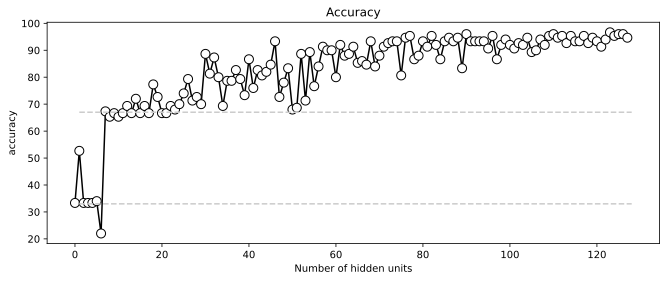

In [ ]:
# report accuracy
fig, ax = plt.subplots(1,figsize=(11,4))

ax.plot(accuracies, 'ko-', markerfacecolor='w', markersize=9)
ax.plot(num_hiddens[[0,-1]], [33,33], '--', color=[.8,.8,.8])
ax.plot(num_hiddens[[0,-1]], [67,67],'--', color=[.8,.8,.8])
ax.set_ylabel('accuracy')
ax.set_xlabel('Number of hidden units')
ax.set_title('Accuracy')
plt.show()

# Depth vs. breadth: number of parameters

In [ ]:
# build two models

widenet = nn.Sequential(
    nn.Linear(2,4),                 # hidden layer
    nn.Linear(4,3),                 # output layer
)

deepnet = nn.Sequential(
    nn.Linear(2,2),                 # hidden layer
    nn.Linear(2,2),                 # hidden layer
    nn.Linear(2,3),                 # output layer
)

# print them out to have a look
print(widenet)
print()
print(deepnet)

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): Linear(in_features=4, out_features=3, bias=True)
)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
  (2): Linear(in_features=2, out_features=3, bias=True)
)


## Peeking inside the network

In [ ]:
# check out the parameters
for p in deepnet.named_parameters():
    print(p)
    print()

('0.weight', Parameter containing:
tensor([[ 0.1775,  0.0226],
        [ 0.2851, -0.1631]], requires_grad=True))

('0.bias', Parameter containing:
tensor([-0.1004, -0.5289], requires_grad=True))

('1.weight', Parameter containing:
tensor([[-0.2684,  0.2494],
        [-0.3702, -0.5951]], requires_grad=True))

('1.bias', Parameter containing:
tensor([-0.2988, -0.1487], requires_grad=True))

('2.weight', Parameter containing:
tensor([[ 0.1190,  0.0110],
        [ 0.4472, -0.0740],
        [-0.1011, -0.3083]], requires_grad=True))

('2.bias', Parameter containing:
tensor([-0.0465,  0.0928, -0.4518], requires_grad=True))



In [ ]:
# count the number of nodes ( = the number of biases)

# named_parameters() is an iterable that returns the tuple (name, numbers)
numNodesInWide = 0
for p in widenet.named_parameters():
    if 'bias' in p[0]:
        numNodesInWide += len(p[1])

numNodesInDeep = 0
for paramName, paramVect in deepnet.named_parameters():
    if 'bias' in paramName:
        numNodesInDeep += len(paramVect)

print('There are %s nodes in the wide network.' % numNodesInWide)
print('There are %s nodes in the deep network.' % numNodesInDeep)

There are 7 nodes in the wide network.
There are 7 nodes in the deep network.


In [ ]:
# just the parameters
for p in widenet.parameters():
    print(p)
    print()

Parameter containing:
tensor([[ 0.4752, -0.1367],
        [ 0.3747,  0.4241],
        [-0.1355, -0.0586],
        [ 0.4965, -0.2006]], requires_grad=True)

Parameter containing:
tensor([ 0.2012,  0.0256, -0.6452, -0.5155], requires_grad=True)

Parameter containing:
tensor([[ 0.4920,  0.1146,  0.4376,  0.3601],
        [-0.2251,  0.0054, -0.2382, -0.3885],
        [-0.3218,  0.4677,  0.4033,  0.0313]], requires_grad=True)

Parameter containing:
tensor([-0.1475,  0.1947, -0.3844], requires_grad=True)



In [ ]:
# now count the total number of trainable parameters
n_params = 0
for p in widenet.parameters():
    if p.requires_grad:
        print('This piece has %s parameters' %p.numel())
        n_params += p.numel()

print('\n\nTotal of %s parameters' %n_params)

This piece has 8 parameters
This piece has 4 parameters
This piece has 12 parameters
This piece has 3 parameters


Total of 27 parameters


In [ ]:
# btw, can also use list comprehension

n_params = np.sum([ p.numel() for p in widenet.parameters() if p.requires_grad ])
print('Widenet has %s parameters' %n_params)

n_params = np.sum([ p.numel() for p in deepnet.parameters() if p.requires_grad ])
print('Deepnet has %s parameters' %n_params)

Widenet has 27 parameters
Deepnet has 21 parameters


In [ ]:
# A nice simple way to print out the model info.
summary(widenet, (1,2))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 4]              12
            Linear-2                 [-1, 1, 3]              15
Total params: 27
Trainable params: 27
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


# Defining models using sequential vs. class

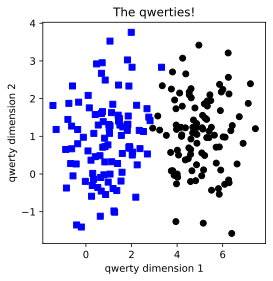

In [ ]:
# create data

nPerClust = 100
blur = 1

A = [1,1]
B = [5,1]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.vstack((
    np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))
))

# concatenate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(4,4))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [ ]:
# define the class
class theClass4ANN(nn.Module):
    def __init__(self):
        super().__init__()

        ### input layer
        self.input = nn.Linear(2,1)

        ### output layer
        self.output = nn.Linear(1,1)

    # forward pass
    def forward(self, x):

        # pass through the input layer
        x = self.input(x)

        # apply relu
        x = F.relu(x)

        # output layer
        x = self.output(x)
        x = torch.sigmoid(x)

        return x

In [ ]:
# create an instance of the class
ANNclassify = theClass4ANN()

In [ ]:
# other model features
learningRate = .01
lossfunc = nn.BCELoss()
optimizer = torch.optim.SGD(ANNclassify.parameters(), lr=learningRate)

# training the model
numepochs = 1000
losses = torch.zeros(numepochs)

for epochi in range(numepochs):

    # forward pass
    yHat = ANNclassify(data)

    # compute loss
    loss = lossfunc(yHat, labels)
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

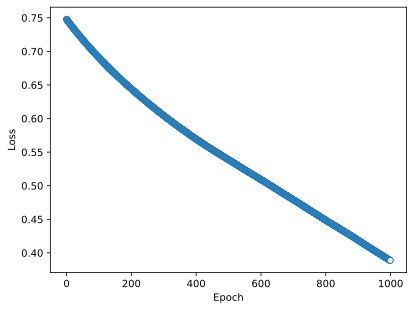

In [ ]:
# show the losses

plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
# compute the predictions

predictions = ANNclassify(data)

predlabels = predictions >.5

misclassified = np.where(predlabels!=labels)[0]

# total accuracy
total_acc = 100 - 100*len(misclassified) / (2*nPerClust)

print('Final accuracy: %g%%' % total_acc)

Final accuracy: 93%


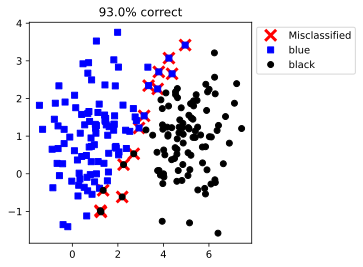

In [ ]:
# plot the labeled data
fig = plt.figure(figsize=(4,4))
plt.plot(data[misclassified,0] ,data[misclassified,1],'rx',markersize=11,markeredgewidth=3)
plt.plot(data[np.where(~predlabels)[0],0],data[np.where(~predlabels)[0],1],'bs')
plt.plot(data[np.where(predlabels)[0],0] ,data[np.where(predlabels)[0],1] ,'ko')

plt.legend(['Misclassified','blue','black'],bbox_to_anchor=(1,1))
plt.title(f'{total_acc}% correct')
plt.show()

# Model depth vs. breadth

In [ ]:
'''
Depth: The number of hidden layers (layers between input and output).
Breadth/width: The number of units per hidden layer (can vary across layers).
'''

## Import and organize the data

In [ ]:
iris = sns.load_dataset('iris', cache=False)

data = torch.tensor(iris[iris.columns[:4]].values).float()

labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

## Construct and sanity-check the model

In [ ]:
# create a class for the model
class ANNiris(nn.Module):
    def __init__(self, nUnits, nLayers):
        super().__init__()

        # create dictionary to store the layers
        self.layers = nn.ModuleDict()
        self.nLayers = nLayers

        ### input layer
        self.layers['input'] = nn.Linear(4, nUnits)

        ### hidden layers
        for i in range(nLayers):
            self.layers[f'hidden_{i}'] = nn.Linear(nUnits, nUnits)

        ### output layer
        self.layers['output'] = nn.Linear(nUnits, 3)

    # forward pass
    def forward(self, x):
        # input layer
        x = F.relu( self.layers['input'](x) )

        # hidden layers
        for i in range(self.nLayers):
            x = F.relu( self.layers[f'hidden_{i}'](x) )

        # return output layer
        x = self.layers['output'](x)
        return x

In [ ]:
# generate an instance of the model and inspect it
nUnitsPerLayer = 12
nLayers = 4

net = ANNiris(nUnitsPerLayer, nLayers)

net

ANNiris(
  (layers): ModuleDict(
    (input): Linear(in_features=4, out_features=12, bias=True)
    (hidden_0): Linear(in_features=12, out_features=12, bias=True)
    (hidden_1): Linear(in_features=12, out_features=12, bias=True)
    (hidden_2): Linear(in_features=12, out_features=12, bias=True)
    (hidden_3): Linear(in_features=12, out_features=12, bias=True)
    (output): Linear(in_features=12, out_features=3, bias=True)
  )
)

In [ ]:
# A quick test of running some numbers through the model.
# This simply ensures that the architecture is internally consistent.

# 10 samples, 4 dimensions
tmp_x = torch.randn(10,4)

# run it through the DL
y = net(tmp_x)

# exam the shape of the output
print(y.shape)
print()

# and the output itself
print(y)

torch.Size([10, 3])

tensor([[ 0.1975, -0.3432, -0.2232],
        [ 0.1951, -0.3458, -0.2152],
        [ 0.2028, -0.3460, -0.2231],
        [ 0.1979, -0.3463, -0.2172],
        [ 0.1959, -0.3479, -0.2127],
        [ 0.1977, -0.3466, -0.2196],
        [ 0.2070, -0.3494, -0.2219],
        [ 0.1881, -0.3436, -0.2105],
        [ 0.1876, -0.3436, -0.2073],
        [ 0.2015, -0.3480, -0.2178]], grad_fn=<AddmmBackward0>)


## Create a function that trains the model

In [ ]:
# a function to train the model
def trainTheModel(theModel):

    # define the loss function and optimizer
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(theModel.parameters(), lr=.01)

    # loop over epochs
    for epochi in range(numepochs):

        # forward pass
        yHat = theModel(data)

        # compute loss
        loss = lossfunc(yHat, labels)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # final forward pass to get accuracy
    predictions = theModel(data)
    predlabels = torch.argmax(predictions, axis=1)
    acc = 100 * torch.mean((predlabels==labels).float()).item()

    # total number of trainable parameters in the model
    nParams = sum(p.numel() for p in theModel.parameters() if p.requires_grad)

    # function outputs
    return acc, nParams

In [ ]:
# test the function once
numepochs = 2500

results = trainTheModel(net)

# check the outputs
results # tuple containing (accuracy, nparams)

(97.33333587646484, 723)

## Now for experiment!

In [ ]:
# define the model parameters
numlayers = range(1,6) # number of hidden layers: 1,2,3,4,5
numunits = np.arange(4,101,3) # units per hidden layer: 4,7,10,...94, 97, 100

# initialize output matrices
accuracies = np.zeros((len(numunits), len(numlayers)))
totalparams = np.zeros((len(numunits), len(numlayers)))

# number of training epochs
numepochs = 500

# start the experiment!
for unit_idx in range(len(numunits)):
    for layer_idx in range(len(numlayers)):

        # create a fresh model instance
        net = ANNiris(numunits[unit_idx], numlayers[layer_idx])

        # run the model and store the accuracy
        acc, nParams = trainTheModel(net)
        accuracies[unit_idx, layer_idx] = acc

        # store the total number of parameters in the model
        totalparams[unit_idx, layer_idx] = nParams

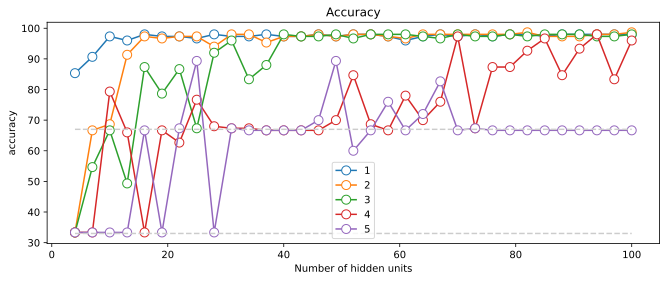

In [ ]:
# show accuracy as a function of model depth
fig, ax = plt.subplots(1, figsize=(11,4))

ax.plot(numunits, accuracies, 'o-', markerfacecolor='w', markersize=9)
ax.plot(numunits[[0,-1]], [33,33], '--', color=[.8,.8,.8])
ax.plot(numunits[[0,-1]],[67,67],'--', color=[.8,.8,.8])
ax.legend(numlayers)
ax.set_ylabel('accuracy')
ax.set_xlabel('Number of hidden units')
ax.set_title('Accuracy')
plt.show()

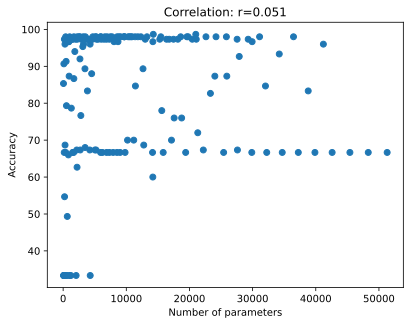

In [ ]:
# Maybe it's simply a matter of more parameters -> better performance?

# vectorize for convenience
x = totalparams.flatten()
y = accuracies.flatten()

# correlation between them
r = np.corrcoef(x,y)[0,1]

# scatter plot
plt.plot(x,y,'o')
plt.xlabel('Number of parameters')
plt.ylabel('Accuracy')
plt.title('Correlation: r=' + str(np.round(r, 3)))
plt.show()

In [ ]:
'''
- Deeper modls are not necessarily better. They require more training and more FLOPs.
- Model performance is not simply a function of the number of trainable parameters. Architecture matters.
- Shallow models learn fast, but deeper models can learn more complex mappings.
'''

# Convert sequential to class

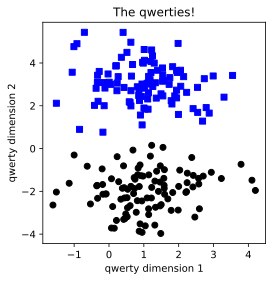

In [9]:
# create data
nPerClust = 100
blur = 1

A = [1,3]
B = [1,-2]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.vstack((
    np.zeros((nPerClust, 1)), np.ones((nPerClust, 1))
))

# concatenate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(4,4))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'bs')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ko')
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

## Functions to build and train the model

In [10]:
def createANNmodel(learningRate):

    class ANNq(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(2,16)

            # hidden layer
            self.hidden = nn.Linear(16,1)

            # output layer
            self.output = nn.Linear(1,1)

        def forward(self, x):

            # input layer
            x = self.input(x)
            x = F.relu(x)

            # hidden layer
            x = self.hidden(x)
            x = F.relu(x)

            # return output layer
            x = self.output(x)
            x = torch.sigmoid(x)
            return x

    # create the model instance
    ANNclassify = ANNq()

    # loss function
    lossfunc = nn.BCELoss()             # better to use BCEWithLogitsLoss (without torch.sigmoid(x))

    # optimizer
    optimizer = torch.optim.SGD(ANNclassify.parameters(), lr=learningRate)

    # model output
    return ANNclassify, lossfunc, optimizer

In [13]:
# a function that trains the model

# a fixed parameter
numepochs = 1000

def trainTheModel(ANNmodel, lossfunc, optimizer):

    # initialize losses
    losses = torch.zeros(numepochs)

    # loop over epochs
    for epochi in range(numepochs):

        # forward pass
        yHat = ANNmodel(data)

        # compute loss
        loss = lossfunc(yHat, labels)
        losses[epochi] = loss.item()

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # final forward pass
    predictions = ANNmodel(data)

    # compute the accuracy
    total_acc = 100 * torch.mean(((predictions>.5)==labels).float()).item()

    return losses, predictions, total_acc

## Test the new code by running it once

Final accuracy: 100%


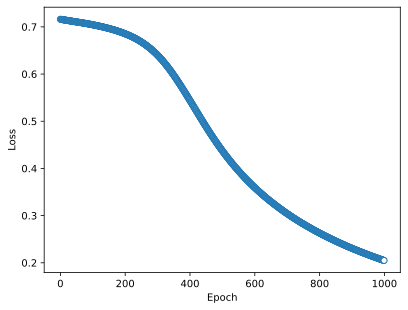

In [14]:
# create everything
ANNclassify, lossfunc, optimizer = createANNmodel(.01)

# run it
losses, predictions, total_acc = trainTheModel(ANNclassify, lossfunc, optimizer)

# report accuracy
print('Final accuracy: %g%%' % total_acc)

# show the losses
plt.plot(losses.detach(), 'o', markerfacecolor='w', linewidth=.1)
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.show()